In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import soundfile as sf
import pandas as pd
import numpy as np
import random
from scipy.constants import speed_of_light as speedlight

# Collect amino acid vibrational frequencies as wavenumbers
!wget https://raw.githubusercontent.com/frodoCombs/Amino_Acid_Frequencies/master/aa_freq.csv -- quiet



--2021-02-19 23:54:20--  https://raw.githubusercontent.com/frodoCombs/Amino_Acid_Frequencies/master/aa_freq.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5460 (5.3K) [text/plain]
Saving to: ‘aa_freq.csv’

aa_freq.csv         100%[===================>]   5.33K  --.-KB/s    in 0s      

2021-02-19 23:54:20 (67.0 MB/s) - ‘aa_freq.csv’ saved [5460/5460]

--2021-02-19 23:54:20--  http://quiet/
Resolving quiet (quiet)... failed: Name or service not known.
wget: unable to resolve host address ‘quiet’
FINISHED --2021-02-19 23:54:20--
Total wall clock time: 0.3s
Downloaded: 1 files, 5.3K in 0s (67.0 MB/s)


In [2]:
# Dictionary to be used for converting amino acid abbreviations
aa_3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S',
'GLN': 'Q', 'LYS':'K','ILE': 'I', 'PRO': 'P',
 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 'GLY': 'G',
 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
 'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}


df = pd.read_csv('/content/aa_freq.csv', sep=',',header=0)


df.fillna(0,inplace=True)


#convert to np array
df = df.values
for ro in range(df.shape[0]):
    for co in range(df.shape[1]):
        if co == 0:
        #Convert amino acid code from 3 letter to 1 letter
            aa = df[ro][co]
            aa = aa[0:3].upper()
            df[ro][co]= aa_3to1[aa]
        else:
        # Convert from wavenumber to frequency
        # wavelength = 1/wavenumber
        # frequency = speed of light / wavelength
            if df[ro][co] > 0:
                freq = speedlight / (1/df[ro][co])


aa_list = df[:,0]      # list of amino acids
df = df[:,1:]          # remove first column                
max_freq = df.max()    # max and min 
min_freq = df.min()    # need to exclude first column
human_range = 20000 - 20
for ro in range(df.shape[0]):
    for co in range(df.shape[1]):
        if df[ro][co] > 0:
            # First scale to 0 to 1
            df[ro][co] = (df[ro][co] - min_freq)/ max_freq - min_freq
            # Scale to human hearing range 20 - 20000 Hz
            df[ro][co] = (df[ro][co] * human_range) + 20

def aa_note(aa,length):
    row = np.where(aa_list == aa)[0][0]
    wave = np.zeros(int(44100 * float(length)))
    harm = 0
 
    for freq in df[row]:
        if freq == 0:
            break
        else:
            volume = np.exp(-harm)
            phases = np.cumsum(2.0 * np.pi * freq / 44100 * np.ones(int(44100 * float(length))))
            wave += np.sin(phases) * volume
            harm += 1
    # scale wave to values between 1 and -1
    wave = 2.*(wave - wave.min())/np.ptp(wave)-1
    return wave




In [3]:
# a sample protein sequence
#https://www.bioinformatics.org/sms2/random_protein.html
protein_sequence = 'VKMSHPSGDVEAILACYEGCCPGSVYGNVVAFLYAALINGERWFVTNTSMSLESYNT'

unit_length = 0.5
melodic_sequence = []
for residue in protein_sequence:
    sound_wave = aa_note(residue,unit_length)
    melodic_sequence = melodic_sequence + sound_wave.tolist()
melody = np.asarray(melodic_sequence)
melody = 2*(melody - melody.min())/np.ptp(melody)-1



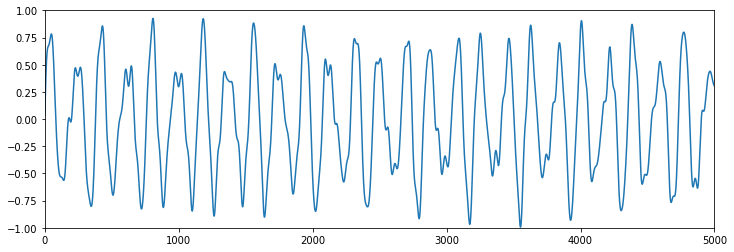

In [5]:
sr=44100
def show_audio(y, sr=44100, xlim=5000):
    fig, ax = plt.subplots(figsize=(12,4))
    ax.set_xlim(0,xlim)
    ax.set_ylim(-1,1)
    ax.plot(y)
    return ipd.Audio(y, rate=sr,  autoplay=True)
    
show_audio(melody, sr)
